In [1]:
import numpy as np
from fractions import Fraction as frac
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import numpy as np
from matplotlib import pyplot as plt
import os
import pwlf
import os
from surface_dynamics.all import *
from Library import *
from Library import Section
import math
from time import time
import copy
from scipy import integrate
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify
import traceback
import dill
Integer = int

In [11]:
class Section:
    def __init__(self, x, top, bottom):
        self.vec = None
        self.pwlf_top = pwlf.PiecewiseLinFit(x, top)
        self.pwlf_bottom = pwlf.PiecewiseLinFit(x, bottom)
        # equations
        self.top = []
        self.bottom = []
        # lambdified equations
        self.f_top = []
        self.f_bottom = []
        # points
        self.points_top = None
        self.points_bottom = None

    def t(self):
        x, y, t = sym.symbols('x y t')
        Mab = np.array([[x, y], [0, 1/x]])
        horo = np.array([[1, 0], [-t, 1]])
        a = horo@(Mab@self.vec)
        return solve(a[1][0], t)[0]

    # find the time equation in terms of y
    def y(self):
        x, y, t = sym.symbols('x y t')
        Mab = np.array([[x, y], [0, 1/x]])
        horo = np.array([[1, 0], [-t, 1]])
        a = horo@(Mab@self.vec)
        return solve(a[1][0], y)[0]


def sec_setup(df, dx_y):
    sec_list = []
    global labs
    labs = df["lab"].unique()
    vec_order = []
    vec_dict = {}
    print(labs)
    for lab in labs:
        sec_dict = {}
        df1 = df[df["lab"] == lab]
        vec_order.append(df1['vec'].iloc[int(0)])
        vec_dict[lab] = df1['vec'].iloc[int(0)]
        xs = df1["x"]
        xs = sorted(list(set(xs.tolist())))
        y_tops = []
        y_bottoms = []
        for x in xs:
            # for a given "x" find the max and minimum y-values
            y_top = max(df1[df1["x"] == x]["y"])
            y_bottom = min(df1[df1["x"] == x]["y"])
            # ensures the section is convex, not concave
            if len(df1[df1["x"] == x]["y"]) < (y_top - y_bottom)/dx_y:
                print("len: " + str(len(df1[df1["x"] == x]["y"])))
                print("ytop: " + str(y_top))
                print("ybottom: " + str(y_bottom))
                print("dx_y: " + str(dx_y))
                print(x)
                print(df1[df1["x"] == x]["y"])
                raise ValueError(
                    "Section has more than 2 points for a given 'x'")
            y_tops.append(y_top)
            y_bottoms.append(y_bottom)
        y_tops = np.array(y_tops)
        y_bottoms = np.array(y_bottoms)
        xs = np.array(xs)
        sec_dict['x'] = xs
        sec_dict['top'] = y_tops
        sec_dict['bottom'] = y_bottoms
        sec_list.append(sec_dict)
    return sec_list, vec_order, vec_dict


def sec_comp(df, sec_list, vec_order, vec_dict, dx, dx_y, m1, y0):
    from fractions import Fraction as frac
    x = Symbol('x')
    
    secs = []
    problem_xs = []
    for i in range(len(sec_list)):
        xs = sec_list[i]['x']
        problem_xs.extend(np.arange(xs[0] - 10*dx, xs[0] + 11*dx, dx))
    problem_xs = list(set(problem_xs))
        
    for i in range(len(sec_list)):
        xs = sec_list[i]['x']
        top = sec_list[i]['top']
        bottom = sec_list[i]['bottom']
        sec = Section(x, top, bottom)
        sec.vec = vec_order[int(i)]

        bottom_lab_list = []
        for x_, y_ in zip(xs, bottom):
            if x_ in problem_xs:
                continue
            poss_ys = sorted(list(df[(df["x"] == x_)]["y"]), reverse = True)
            y_index = poss_ys.index(y_)
        
            # Check if index + 1 is valid
            if y_index + 1 < len(poss_ys):
                # Get the value at index + 1
                next_y = poss_ys[y_index + 1]
                filtered_df = df[(df["x"] == x_) & (df["y"] == next_y)]
                lab_value = filtered_df["lab"].iloc[0]  # Get the value in the "lab" column of the first row
                if lab_value not in bottom_lab_list:
                    bottom_lab_list.append(lab_value)
            else:
                if -1 not in bottom_lab_list:
                    bottom_lab_list.append(int(-1))

        eqs = []
        print(bottom_lab_list)
        for lab in bottom_lab_list:
            if lab != -1:
                vec = vec_dict[lab]
                eqs.append(-frac(vec[0][0],vec[1][0]) * x + frac(int(1)/vec[1][0]))
            else:
                eqs.append(frac(m1) * x + frac(int(1)/y0))

        points = [xs[0]]
        for i in range(len(eqs) - 1):
            eq1 = eqs[i]
            eq2 = eqs[i + 1]
            # Set eq1 = eq2 and solve for x
            intersection_x = solve(Eq(eq1, eq2), x)
            if intersection_x:  # If there is a solution
                points.append(intersection_x[0])

        sec.top.append(-frac(sec.vec[0][0], sec.vec[1][0]) * x + frac(int(1)/sec.vec[1][0]))
        sec.f_top.append(lambdify([x], sec.top))
        sec.points_top = [0]
        
        for eq in eqs:
            sec.bottom.append(eq)
            sec.f_bottom.append(lambdify([x], eq))
            sec.points_bottom = points
            
        secs.append(sec)
    return secs

In [43]:
def print_secs(secs):
    j = 0
    for sec in secs:
        j+=1
        output = str(j) + ".\n"
        output = output + "x0 = " + str(simplify(sec.vec[0][0])) + ";\n"
        output = output + "y0 = " + str(simplify(sec.vec[1][0])) + ";\n"
        output = output + "\n"
        output = output + "top = " + str(simplify_eq(sec.top[0])) + ";\n"
        for i in range(len(sec.bottom)):
            output = output + "bottom" + str(i+1) + " = " + str(simplify_eq(sec.bottom[i])) + ";\n"
        for i in range(len(sec.points_bottom)):
            if i == 0:
                continue
            output = output + "point" + str(i) + " = " + str(simplify(sec.points_bottom[i])) + ";\n"
        output = output + "left = " + str(simplify(sec.points_bottom[0])) + ";\n"
        print(output)
        print("--------------------------------------------------\n")

def simplify_eq(expr):
    dict = expr.as_coefficients_dict()
    b = dict[1]
    m = dict[x]

    m1 = None
    b1 = None

    m_num = None
    m_den = None
    b_num = None
    b_den = None
    
    m_diff = 1
    b_diff = 1
    m_decimal = m - int(m)
    b_decimal = b - int(b)
    
    for i in range(10, 0, -1):
        for j in range(i+1):
            if(m < 0):
                m_result = abs(j/i + m_decimal)
            else:
                m_result = abs(j/i - m_decimal)

            if(b < 0):
                b_result = abs(j/i + b_decimal)
            else:
                b_result = abs(j/i - b_decimal)

            if(m_result <= m_diff):
                m_diff = m_result
                if (m < 0):
                    m_num = int(m)*i - j
                    m_den = i
                else:
                    m_num = int(m)*i + j
                    m_den = i

            if(b_result <= b_diff):
                b_diff = b_result
                if (b < 0):
                    b_num = int(b)*i - j
                    b_den = i
                else:
                    b_num = int(b)*i + j
                    b_den = i
                    
    if(m_den == 1):
        m1 = str(m_num)
    else:
        m1 = str(m_num) + "/" + str(m_den)

    if(b_den == 1):
        b1 = str(b_num)
    else:
        b1 = str(b_num) + "/" + str(b_den)
        
    return  m1 + "*x + " + b1

def simplify(m):

    m1 = None

    m_num = None
    m_den = None
    
    m_diff = 1
    m_decimal = m - int(m)
    
    for i in range(10, 0, -1):
        for j in range(i+1):
            if(m < 0):
                m_result = abs(j/i + m_decimal)
            else:
                m_result = abs(j/i - m_decimal)

            if(m_result <= m_diff):
                m_diff = m_result
                if (m < 0):
                    m_num = int(m)*i - j
                    m_den = i
                else:
                    m_num = int(m)*i + j
                    m_den = i
                    
    if(m_den == 1):
        m1 = str(m_num)
    else:
        m1 = str(m_num) + "/" + str(m_den)
        
    return  m1

In [44]:
# 7-0, 7-3, 7-7, 7-19, 7-29, 7-41
n_squares = 7
index = 19
j = 9
dx = 0.0005

In [45]:
permutations = perms_list(n_squares)
perm = permutations[index]

vec_file = "vecs" + str(n_squares) + "-" + str(index) + ".npy"
vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))

with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
    loaded_data = dill.load(f)
a,c,e,g = loaded_data

df = read_df(n_squares, index, j)

with open(os.path.join("results", f"{n_squares} - {index}", f"secs - {j}.dill"), 'rb') as f:
    secs = dill.load(f)

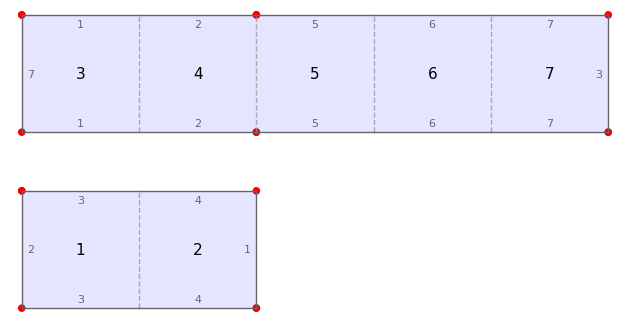

In [46]:
perm.show()

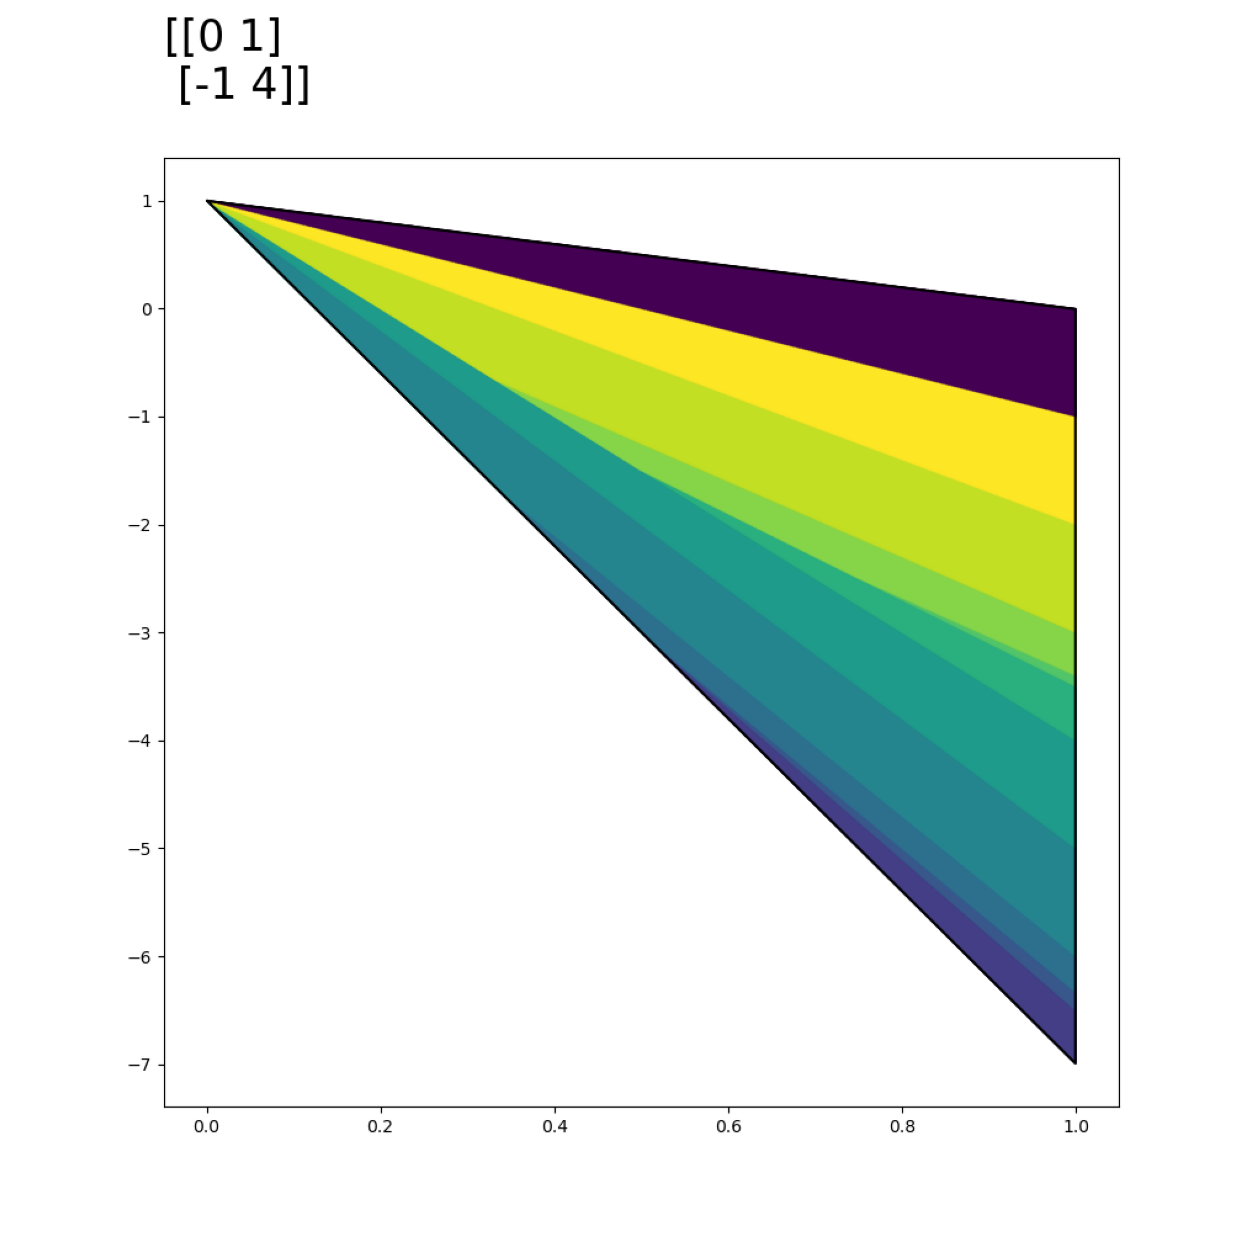

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your saved PNG file
image_path = os.path.join("results", f"{n_squares} - {index}", f"section - {j}.png")

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)

plt.figure(figsize=(20, 16))  # Adjust the numbers to make the image bigger (width, height in inches)

plt.imshow(img)
plt.axis('off')  # Remove axes for cleaner display
plt.show()


In [48]:
print_secs(secs)

1.
x0 = 3;
y0 = 1;

top = -3*x + 1;
bottom1 = -5*x + 1;
bottom2 = -7/2*x + 1/2;
point1 = 1/3;
point2 = 1;
left = 0;

--------------------------------------------------

2.
x0 = 5;
y0 = 1;

top = -5*x + 1;
bottom1 = -6*x + 1;
point1 = 1;
left = 0;

--------------------------------------------------

3.
x0 = 6;
y0 = 1;

top = -6*x + 1;
bottom1 = -8*x + 1;
bottom2 = -13/2*x + 1/2;
point1 = 1/3;
point2 = 1;
left = 0;

--------------------------------------------------

4.
x0 = 2;
y0 = 1;

top = -2*x + 1;
bottom1 = -3*x + 1;
point1 = 1;
left = 0;

--------------------------------------------------

5.
x0 = 1;
y0 = 1;

top = -1*x + 1;
bottom1 = -2*x + 1;
point1 = 1;
left = 0;

--------------------------------------------------

6.
x0 = 7;
y0 = 2;

top = -7/2*x + 1/2;
bottom1 = -49/10*x + 1;
bottom2 = -34/9*x + 3/8;
point1 = 5/9;
point2 = 1;
left = 1/3;

--------------------------------------------------

7.
x0 = 13;
y0 = 2;

top = -13/2*x + 1/2;
bottom1 = -55/8*x + 1/2;
point1 = 1;
left = 1/

In [49]:
dx_y = 7 * dx
sec_list, vec_order, vec_dict = sec_setup(df, dx_y)
secs = sec_comp(df, sec_list, vec_order, vec_dict, dx, dx_y, int(-8), 1)

[10  6  5 11  0  9  4  7  3  2  8]
[6, 9]
[5]
[-1, 4]
[10]
[11]
[6, 7, 8]
[-1, 3]
[6]
[2]
[-1]
[7]


In [50]:
print_secs(secs)

1.
x0 = 3;
y0 = 1;

top = -3*x + 1;
bottom1 = -5*x + 1;
bottom2 = -7/2*x + 1/2;
point1 = 1/3;
left = 0;

--------------------------------------------------

2.
x0 = 5;
y0 = 1;

top = -5*x + 1;
bottom1 = -6*x + 1;
left = 0;

--------------------------------------------------

3.
x0 = 6;
y0 = 1;

top = -6*x + 1;
bottom1 = -8*x + 1;
bottom2 = -13/2*x + 1/2;
point1 = 1/3;
left = 0;

--------------------------------------------------

4.
x0 = 2;
y0 = 1;

top = -2*x + 1;
bottom1 = -3*x + 1;
left = 0;

--------------------------------------------------

5.
x0 = 1;
y0 = 1;

top = -1*x + 1;
bottom1 = -2*x + 1;
left = 0;

--------------------------------------------------

6.
x0 = 7;
y0 = 2;

top = -7/2*x + 1/2;
bottom1 = -5*x + 1;
bottom2 = -4*x + 1/2;
bottom3 = -18/5*x + 1/5;
point1 = 1/2;
point2 = 3/4;
left = 1/3;

--------------------------------------------------

7.
x0 = 13;
y0 = 2;

top = -13/2*x + 1/2;
bottom1 = -8*x + 1;
bottom2 = -20/3*x + 1/3;
point1 = 1/2;
left = 1/3;

--------------